# cGAN version

## our basic GAN doesn't use any of the labels

## we need to conditioned both the generator and discriminator on class labels

In [20]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv3D, Conv3DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, multiply, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import glob
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

In [2]:
# List all physical devices of type 'GPU'
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print(f'Number of GPUs available: {len(gpus)}')
    for i, gpu in enumerate(gpus):
        print(f'GPU {i}: {gpu}')
else:
    print('No GPU detected.')

Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Matching fMRI files with IDs from demographic csv

In [3]:
# Specify the directory and file pattern
directory_path = '4D'
file_pattern = 'A*_????_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz'

# Construct the full path pattern
path_pattern = f'{directory_path}/{file_pattern}'

# Use glob to find all matching files
matching_files = glob.glob(path_pattern)

# Define the list of schizophrenia IDs

schizophrenia_ids = [
    'A00009280', 'A00028806', 'A00023132', 'A00014804', 'A00016859']

'''
schizophrenia_ids = [
    'A00009280', 'A00028806', 'A00023132', 'A00014804', 'A00016859', 'A00021598', 'A00001181', 'A00023158',
    'A00024568', 'A00028405', 'A00001251', 'A00000456', 'A00015648', 'A00002405', 'A00027391', 'A00016720',
    'A00018434', 'A00016197', 'A00027119', 'A00006754', 'A00009656', 'A00038441', 'A00012767', 'A00034273',
    'A00028404', 'A00035485', 'A00024684', 'A00018979', 'A00027537', 'A00004507', 'A00001452', 'A00023246',
    'A00027410', 'A00014719', 'A00024510', 'A00000368', 'A00019293', 'A00014830', 'A00015201', 'A00018403',
    'A00037854', 'A00024198', 'A00001243', 'A00014590', 'A00002337', 'A00024953', 'A00037224', 'A00027616',
    'A00001856', 'A00037619', 'A00024228', 'A00038624', 'A00037034', 'A00037649', 'A00022500', 'A00013216',
    'A00020787', 'A00028410', 'A00002480', 'A00028303', 'A00020602', 'A00024959', 'A00018598', 'A00014636',
    'A00019349', 'A00017147', 'A00023590', 'A00023750', 'A00031597', 'A00015518', 'A00018317', 'A00016723',
    'A00021591', 'A00023243', 'A00017943', 'A00023366', 'A00014607', 'A00020414', 'A00035003', 'A00028805',
    'A00029486', 'A00000541', 'A00028408', 'A00000909', 'A00031186', 'A00000838' ] '''


# Define the list of IDs of individuals with non-schizophrenia - control only
control_ids = [
    'A00007409', 'A00013140', 'A00021145', 'A00036049', 'A00022810',]

'''
    control_ids = [
    'A00007409', 'A00013140', 'A00021145', 'A00036049', 'A00022810', 'A00002198', 'A00020895', 'A00004667',
    'A00015826', 'A00023120', 'A00022837', 'A00010684', 'A00009946', 'A00037318', 'A00033214', 'A00022490',
    'A00023848', 'A00029452', 'A00037564', 'A00036555', 'A00023095', 'A00022729', 'A00024955', 'A00024160',
    'A00011725', 'A00027487', 'A00024446', 'A00014898', 'A00015759', 'A00028409', 'A00017294', 'A00014522',
    'A00012995', 'A00031764', 'A00025969', 'A00033147', 'A00018553', 'A00023143', 'A00036916', 'A00028052',
    'A00023337', 'A00023730', 'A00020805', 'A00020984', 'A00000300', 'A00010150', 'A00024932', 'A00035537',
    'A00022509', 'A00028406', 'A00004087', 'A00035751', 'A00023800', 'A00027787', 'A00022687', 'A00023866',
    'A00021085', 'A00022619', 'A00036897', 'A00019888', 'A00021058', 'A00022835', 'A00037495', 'A00026945',
    'A00018716', 'A00026907', 'A00023330', 'A00016199', 'A00037238', 'A00023131', 'A00014120', 'A00021072',
    'A00037665', 'A00022400', 'A00003150', 'A00024372', 'A00021081', 'A00022592', 'A00022653', 'A00013816',
    'A00014839', 'A00031478', 'A00014225', 'A00013363', 'A00037007', 'A00020968', 'A00024301', 'A00024820',
    'A00035469', 'A00029226', 'A00022915', 'A00022773', 'A00024663', 'A00036844', 'A00009207', 'A00024535',
    'A00022727', 'A00011265', 'A00024546'
] '''



"\n    control_ids = [\n    'A00007409', 'A00013140', 'A00021145', 'A00036049', 'A00022810', 'A00002198', 'A00020895', 'A00004667',\n    'A00015826', 'A00023120', 'A00022837', 'A00010684', 'A00009946', 'A00037318', 'A00033214', 'A00022490',\n    'A00023848', 'A00029452', 'A00037564', 'A00036555', 'A00023095', 'A00022729', 'A00024955', 'A00024160',\n    'A00011725', 'A00027487', 'A00024446', 'A00014898', 'A00015759', 'A00028409', 'A00017294', 'A00014522',\n    'A00012995', 'A00031764', 'A00025969', 'A00033147', 'A00018553', 'A00023143', 'A00036916', 'A00028052',\n    'A00023337', 'A00023730', 'A00020805', 'A00020984', 'A00000300', 'A00010150', 'A00024932', 'A00035537',\n    'A00022509', 'A00028406', 'A00004087', 'A00035751', 'A00023800', 'A00027787', 'A00022687', 'A00023866',\n    'A00021085', 'A00022619', 'A00036897', 'A00019888', 'A00021058', 'A00022835', 'A00037495', 'A00026945',\n    'A00018716', 'A00026907', 'A00023330', 'A00016199', 'A00037238', 'A00023131', 'A00014120', 'A0002107

In [4]:
# Initialize lists to store the processed image data, corresponding labels, and filenames
image_data = []
labels = []  # 1 for schizophrenia, 0 for non-schizophrenia
schizophrenia_files = []
non_schizophrenia_files = []

# Lists for files with insufficient time dimensions
insufficient_time_files = []
insufficient_time_ids = []

# Counters for each category
schizophrenia_count = 0
non_schizophrenia_count = 0
processed_files_count = 0

# Loop through the matching files
for file_path in matching_files:
    # Extract the filename
    filename = os.path.basename(file_path)
    
    # Extract the ID from the filename
    file_id = filename.split('_')[0]
    
    # Load the file
    t1_img = nib.load(file_path)
    t1_data = t1_img.get_fdata()

    # Check if the time dimension is at least 90
    if t1_data.shape[3] < 90:
        insufficient_time_files.append(filename)
        insufficient_time_ids.append(file_id)
        continue  # Skip this file

    # Determine the label based on the ID and increment counters
    if file_id in schizophrenia_ids:
        label = 1  # Schizophrenia
        schizophrenia_count += 1
        schizophrenia_files.append(filename)
    elif file_id in control_ids:
        label = 0  # Non-Schizophrenia
        non_schizophrenia_count += 1
        non_schizophrenia_files.append(filename)
    else:
        continue  # Skip files with IDs not in the provided lists
    
    # Collapse one of the axes by summing
    t1_data_collapsed = np.sum(t1_data, axis=1)
    
    # Append the collapsed image data and label to the respective lists
    image_data.append(t1_data_collapsed)
    labels.append(label)

    # Increment the counter
    processed_files_count += 1

# Print the total number of files processed for each category and their filenames
print(f"Total number of files successfully processed: {processed_files_count}")
print(f"Total number of schizophrenia files: {schizophrenia_count}")
print("Schizophrenia files:", schizophrenia_files)
print(f"Total number of non-schizophrenia files: {non_schizophrenia_count}")
print("Non-Schizophrenia files:", non_schizophrenia_files)

# Print files with insufficient time dimension
print(f"Total number of files with insufficient time dimension: {len(insufficient_time_files)}")
print("Files with insufficient time dimension:", insufficient_time_files)
print("IDs of files with insufficient time dimension:", insufficient_time_ids)


Total number of files successfully processed: 7
Total number of schizophrenia files: 3
Schizophrenia files: ['A00009280_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00014804_0014_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00028806_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz']
Total number of non-schizophrenia files: 4
Non-Schizophrenia files: ['A00007409_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00013140_0011_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00022810_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00036049_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz']
Total number of files with insufficient time dimension: 28
Files with insufficient time dimension: ['A00000909_0011_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00001181_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00001243_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A

In [5]:
# Determine the maximum z-dimension size
max_z_size = max(img.shape[2] for img in image_data)
max_z_size

143

In [6]:
image_data_normalized = [(img - np.min(img)) / (np.max(img) - np.min(img)) * 2 - 1 for img in image_data]

In [7]:
image_data_normalized[0]

array([[[-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        [-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        [-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        ...,
        [-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        [-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        [-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606]],

       [[-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        [-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        [-0.05646606, -0.05646606, -0.05646606, ..., -0.05646606,
         -0.05646606, -0.05646606],
        ...,
        [-0.05646606, -0.05646606, -0.05646606, ..., -

In [8]:
# Pad each image to have a consistent z-dimension size
padded_data = [np.pad(img, ((0, 0), (0, 0), (0, max_z_size - img.shape[2])), mode='constant') for img in image_data_normalized]

# Now convert the padded data list to a numpy array
padded_data_array = np.array(padded_data)

In [9]:
print(len(labels))

7


In [10]:
train_images = padded_data_array
# Define batch size
batch_size = 32


train_dataset = tf.data.Dataset.from_tensor_slices((train_images, labels)).shuffle(len(train_images)).batch(batch_size)

In [11]:
def build_cgan_generator(z_dim, num_classes):
    # Noise input
    z_input = Input(shape=(z_dim,))
    # Label input
    label_input = Input(shape=(1,), dtype='int32')

    # Embedding for the label
    #  Embedding funciton transforms integer labels into a dense vector of length z_dim.
    # the embedding layer creates a dense representation where each label is mapped to a vector in a continuous space
    # maybe we should try one-hot encoding?
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)

    # Merge noise and label
    joined_representation = multiply([z_input, label_embedding])

    # Generator network using joined representation
    model = Sequential()
    
     # Start with a Dense layer to an initial shape that's smaller than the final target
    model.add(Dense(128 * 7 * 7 * 9, input_dim=z_dim))  # Adjust to match an initial volume
    model.add(LeakyReLU(alpha=0.01))
    model.add(Reshape((7, 7, 9, 128)))  # This is the initial volume
    
    # Begin upsampling to the desired size
    model.add(Conv3DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    # Continue upsampling
    model.add(Conv3DTranspose(32, kernel_size=3, strides=(3, 3, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    # Final upsampling step to reach just under the target size
    # You may need to adjust the strides or padding to get the exact output size desired
    model.add(Conv3DTranspose(1, kernel_size=3, strides=(2, 2, 2), padding='same', activation='tanh'))



    # Use the model's call method to get the output tensor
    output = model(joined_representation)

    return Model([z_input, label_input], output)


In [12]:
def build_cgan_discriminator(img_shape, num_classes):
    # Image input
    img_input = Input(shape=img_shape)

    # Label input
    label_input = Input(shape=(1,), dtype='int32')

    # Embedding for the label
    label_embedding = Embedding(num_classes, np.prod(img_shape[:-1]), input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape[:-1] + (1,))(label_embedding)  # Reshape to match image dimensions

  
    # Merge image and label
    concatenated = Concatenate(axis=-1)([img_input, label_embedding])

    # Discriminator network using concatenated input
    model = Sequential()
 
    model.add(Conv3D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_shape[0], img_shape[1], img_shape[2], img_shape[3] + 1)))  # Adjust to 2 channels
    model.add(LeakyReLU(alpha=0.01))
    
    # More layers with downsampling
    model.add(Conv3D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    # Flatten and add Dense layers for classification
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    # Use the model's call method to get the output tensor
    output = model(concatenated)

    return Model([img_input, label_input], output)


In [21]:
# this follows from the generator architecture
img_shape = (84,84,72,1)

#  Define the dimensions of the noise vector and number of classes
z_dim = 100
num_classes = 2

# Define the optimizer with the specified learning rate and momentum
adam_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Build the generator and discriminator
generator = build_cgan_generator(z_dim, num_classes)
discriminator = build_cgan_discriminator(img_shape, num_classes)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# For the combined model we will only train the generator
discriminator.trainable = False

# cGAN model
z_input = Input(shape=(z_dim,))
label_input = Input(shape=(1,))
generated_image = generator([z_input, label_input])
validity = discriminator([generated_image, label_input])

# The combined model (stacked generator and discriminator)
cgan_model = Model([z_input, label_input], validity)
cgan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)


In [22]:
def resize_image(image, new_shape):
    factors = (
        new_shape[0]/image.shape[0],
        new_shape[1]/image.shape[1],
        new_shape[2]/image.shape[2]
    )
    return scipy.ndimage.zoom(image, factors, order=1)  # order=1 is bilinear interpolation


In [23]:
def train_cgan(gan, dataset, z_dim, epochs, num_classes):
    #generator, discriminator = gan.layers
    d_losses = []
    g_losses = []

      # Directory for saving checkpoints
    checkpoint_dir = "cgan_checkpoints"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(epochs):
        epoch_d_loss = 0.0
        epoch_g_loss = 0.0
        num_batches = 0
        
        for real_imgs, labels in dataset:
            num_batches += 1
            batch_size = real_imgs.shape[0]


             # Resize the real images to match the dimensions expected by the discriminator
            real_imgs_resized = np.array([resize_image(img, (84, 84, 72)) for img in real_imgs])

            # Generate random noise and a batch of labels for fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            random_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

            # Generate a batch of fake images using the random noise and labels
            fake_imgs = generator.predict([z, random_labels])

            # Labels for real and fake images
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch([real_imgs_resized, labels], real_labels)
            d_loss_fake = discriminator.train_on_batch([fake_imgs, random_labels], fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            epoch_d_loss += d_loss[0]

            # Mislabel the fake images as real for generator training
            z = np.random.normal(0, 1, (batch_size, z_dim))
            random_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            misleading_labels = np.ones((batch_size, 1))

            # Train the generator (through the combined model)
            g_loss = gan.train_on_batch([z, random_labels], misleading_labels)
            epoch_g_loss += g_loss

            # Optionally, print the losses for each batch
            print(f'Epoch: {epoch}, Batch: {num_batches}, D Loss: {d_loss[0]}, G Loss: {g_loss}')


        # Checkpointing every n epochs
        if (epoch + 1) % 2 == 0:
            generator.save_weights(os.path.join(checkpoint_dir, f"generator_epoch_{epoch+1}.h5"))
            discriminator.save_weights(os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch+1}.h5"))
            print(f"Checkpoint: Saved model weights at epoch {epoch+1}")
            
        # Record the average losses for this epoch
        d_losses.append(epoch_d_loss / num_batches)
        g_losses.append(epoch_g_loss / num_batches)

    return d_losses, g_losses


In [24]:
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [25]:
# Assuming train_dataset is structured to yield both images and labels
# and that the number of classes (e.g., schizophrenia and non-schizophrenia) is known
num_classes = 2  # Update this as per your dataset

d_losses, g_losses = train_cgan(cgan_model, train_dataset, z_dim=100, epochs=10, num_classes=num_classes)

1/1 [==============================] - 0s 83ms/step
Epoch: 0, Batch: 1, D Loss: 1.041176289319992, G Loss: 0.5331854224205017
1/1 [==============================] - 0s 15ms/step
Epoch: 1, Batch: 1, D Loss: 0.4357974324375391, G Loss: 0.680171549320221
Checkpoint: Saved model weights at epoch 2
1/1 [==============================] - 0s 16ms/step
Epoch: 2, Batch: 1, D Loss: 0.38605090603232384, G Loss: 0.6949500441551208
1/1 [==============================] - 0s 15ms/step
Epoch: 3, Batch: 1, D Loss: 0.3555691549554467, G Loss: 0.7845475077629089
Checkpoint: Saved model weights at epoch 4
1/1 [==============================] - 0s 17ms/step
Epoch: 4, Batch: 1, D Loss: 0.2836084009613842, G Loss: 1.114147424697876
1/1 [==============================] - 0s 16ms/step
Epoch: 5, Batch: 1, D Loss: 0.1580008422024548, G Loss: 2.798711061477661
Checkpoint: Saved model weights at epoch 6
1/1 [==============================] - 0s 19ms/step
Epoch: 6, Batch: 1, D Loss: 0.362565815448761, G Loss: 2.319

1/1 [==============================] - 0s 86ms/step


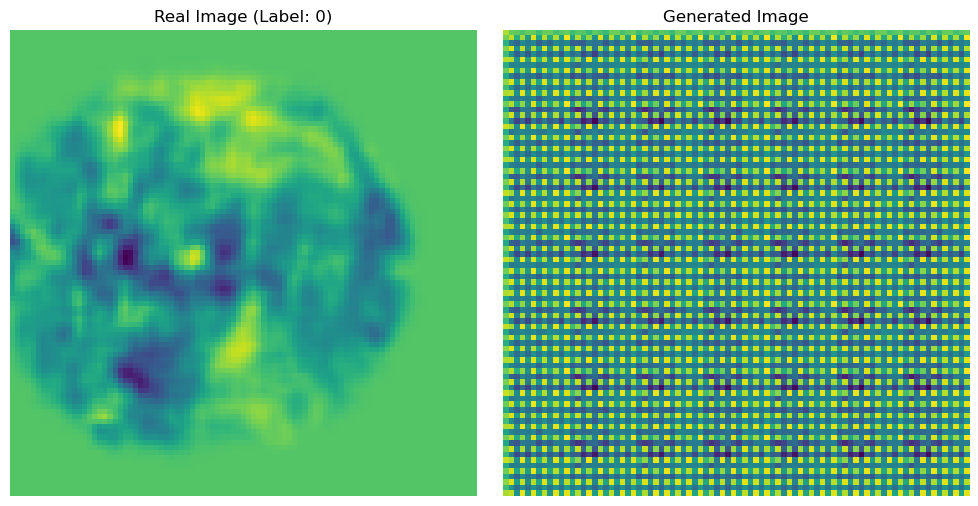

In [18]:
# Specify the label you want to condition on
# (e.g., 0 for non-schizophrenia, 1 for schizophrenia)
condition_label = np.array([[0]])

# Generate a single fake image
z = np.random.normal(0, 1, (1, z_dim))
generated_image = generator.predict([z, condition_label])[0]  # [0] to get the single image from the batch

# Get a single real image and its label
real_images, labels = next(iter(train_dataset))

# Create a mask for images with the desired label
mask = (labels.numpy().flatten() == condition_label[0, 0])

# Apply the mask to the real_images to filter out those with the matching label
filtered_real_images = real_images[mask]

# Check if there are any images that match the condition label
if len(filtered_real_images) > 0:
    real_image = filtered_real_images[0]  # Take the first image that matches
    real_label = condition_label[0, 0]
else:
    raise ValueError("No real images found with the specified condition label")

# Plot the real and fake images side by side
plt.figure(figsize=(10, 5))

# Plot real image
plt.subplot(1, 2, 1)
plt.imshow(real_image[:, :, 10])  # adjust indexing based on your image data format
plt.title(f'Real Image (Label: {real_label})')
plt.axis('off')

# Plot fake image
plt.subplot(1, 2, 2)
plt.imshow(generated_image[:, :, 10])  # adjust indexing based on your image data format
plt.title('Generated Image')
plt.axis('off')

plt.tight_layout()
plt.show()



In [19]:
# Save the generator, discriminator, and the entire GAN
generator.save('cgan_generator_model_v1.h5')
discriminator.save('cgan_discriminator_model_v1.h5')
cgan_model.save('cgan_model_v1.h5')
